# Pandas: Possibly the best way to work with tabular data

Most of the data you'll ever work with can be represented as tabular data, with rows and columns.  CSV, Excel, Parquet, SQL, and even a lot of JSON data are all great examples.  The Pandas library provides a lot of extremely nice tools for manipulating and analyzing this kind of tabular data.  In many ways, Pandas is *the* Python libary for tabular data analysis--much like how Numpy is *the* Python library for a lot of numeric analysis.  (Numpy and Pandas are actually very similar--Pandas actually builds on top of Numpy, and adds extra functionality that's more specifically tailored to analyzing real-world datasets, whereas Numpy is highly specialized for purely numeric data).

Install Pandas with:

```bash
conda install pandas
```

We'll also need the `openpyxl` library to read and write Excel files:

```bash
conda install openpyxl
```

NOTE: we'll be seeing a *lot* of stuff tonight, and we'll only be going over it very briefly.  There are a lot of functions and methods in Pandas that we will only just scratch the surface of.  Moreso than before, you *need* to spend some time with the Pandas documentation, learning the different arguments and how to use the different things we'll see tonight.

# Basic design principles of Pandas

Pandas is, like many libraries we've seen recently, *huge.*  There is a mind-boggling amount of stuff in it.  But, in terms of the basic building blocks, there are only really a few important concepts:

- `DataFrame`s: the format your data gets converted into, and the thing you'll spend most of your time interacting with.  (R users: yes, this is the same kind of object as `data.frame`/`data.table`/`tibble`s!  In fact, it was originally inspired by R's `data.frame`, though in my opinion, Pandas' `DataFrame` have long since surpassed the offerings on R).
- `Series`: the data structure used for storing columns and one-dimensional data.  They act like a cross between Numpy `array`s and Python `dict`ionaries.  You won't interact with these directly all that often.
- Indexes: `DataFrame`s and `Series` objects have row indexes: unique values (or unique combinations of values) that identify each row.  These can be the cause of a lot of frustration and weird behavior when starting out.
- Method chaining: this isn't unique to Pandas, but Pandas is very friendly to *method chaining.*  This is Python's equivalent of *piping* (e.g., using `magrittr`'s `%>%` in R, or `|` in shell/command line scripting).
- There are a few new data types that Pandas introduces--like time and date formats, and categorical formats.

If you understand the basics of `DataFrame`s, are aware of `Series` and indexes and the fact that there are new data types, and you're comfortable with the idea of method chaining, almost everything else in Pandas will boil down to learning how a particular function/method changes your `DataFrame`.

## The `DataFrame`

The `DataFrame` is the most important piece of the library, and is kind of what the whole library is built around.  Fortunately, the basic idea behind `DataFrame`s is very simple:  *a `DataFrame` should look and act like a `dict` of Numpy `array`s.*  While they store tabular data, and while you can (quite easily) access data by selecting specific rows, the "basic" interface to `DataFrame`s prioritizes easy *column* access.  This might sound a bit odd, but most of the time, this is how you want to interact with your tabular data anyways.

Remember all the time we spent on Numpy last month?  Here's where it's going to come back: `DataFrame`s are almost fully compatible with Numpy (since they're ultimately built on Numpy's `array` objects).  This means all the fast Numpy math functions can be run on your `DataFrame`s!  In fact, a `DataFrame` containing just numeric data will often act like a Numpy `array` with named columns.  But *unlike* Numpy `array`s, `DataFrame`s are type-heterogeneous.  Sort of.  Every *column* must be the same type (like Numpy, Pandas calls these `dtype`s (for `d`ata `type`s).  But, one `DataFrame` can have multiple columns of different types.

This also mean that most operations over `DataFrame`s are vectorized!

## Indexes

All Pandas objects have some notion of an *index*.  An index is just a set of unique identifiers for each *row* that can be used for very fast row-level lookups.  Indexes are usually columns in your `DataFrame`s, and there might be more than one column that goes into an index.  Indexes have a few important properties:
- They are NOT accessed like normal columns.  You can't just index your `DataFrame` to get them.
- You can convert your index columns to normal columns using the `.reset_index()` method.  You can convert normal columns to index columns using the `.set_index()` method.
- They are OMITTED from most operations over `DataFrames`, e.g., if you calculate the per-column maximum, the indexes aren't used in that calculation.
- Indexes must be UNIQUE for each row.  (if you have multiple columns serving as your index: the *combinations* must be unique).
- Some ways of combining dataframes or adding columns can sometimes cause weird behavior if the indexes don't line up.  This can be a huge source of frustration.  Fortunately: you can usually get around it by calling `.reset_index()` 

This probably seems pretty abstract and esoteric at the moment, and that's fine.  Just remember: indexes are to rows what column names are to, well, columns.  And they can sometimes cause issues.

## The `Series`

This deserves only a brief mention.  Technically, a `DataFrame` is not a `dict`ionary of Numpy `array`s, but an *indexable collection of Pandas `Series` objects.*  (This difference is mostly in the implementation--if you think of them like `dict`ionaries of `array`s, you'll be fine, at least when getting started).  A Pandas `Series` is essentially just a one-dimensional Numpy `array`, but with an index you can use to access elements.  So, they act kind of like a weird mix of `list`s, Numpy `array`s, and `dict`ionaries.  You usually won't be dealing with `Series` objects directly, at least not at first, so they're not critical to understand just now.  But they're important to have on your radar.

The one place they might cause problems, though, is if you're copying the columnd of one `DataFrame` into another.  Even if they have the same number of rows, the indexes might be different.

## Method chaining

Most of the transformations and manipulations we do with `DataFrame`s are done through method calls.  Pretty much every method call on a `DataFrame` will return a new `DataFrame`, meaning you can do something called *method chaining.*  Consider the following example with strings:

In [1]:
my_string = "1001000 1100101 1101100 1101100 1101111 100001"
print(my_string)
my_string = (
    my_string
    .replace("1001000", "H")
    .replace("1100101", "e")
    .replace("1101100", "l")
    .replace("1101111", "o")
    .replace("100001", "!")
    .replace(" ", "")
)
print(my_string)

1001000 1100101 1101100 1101100 1101111 100001
Hello!


(Note: the parentheses starting on the third line are syntactically important here.  They tell Python that everything inside of them is a single expression, even if it's spread across multiple lines.  This lets us avoid having one very, very long line with a lot of .replace() calls, and it lets us not have to use an ugly backslash at the end of every line to tell Python "the expression continues on the next line").

Every time we call `my_string.replace(...)`, we get a brand new `str`ing back.  So, we can just tack another `.replace(...)` right after that expression.  Remember that Python essentially evaluates these expressions "from the inside out": `my_string.replace(...)` gets evaluated, and then replaced with whatever its result (i.e., its *return value*) is.  Since the return value is a string, we now have `[a string].replace(...)`, and the process repeats.

This paradigm is called *method chaining,* since we're "chaining" multiple method calls, one after another, without stopping.  We *could* write the code like this:

```python
my_string = "1001000 1100101 1101100 1101100 1101111 100001"
my_string = my_string.replace("1001000", "H")
my_string = my_string.replace("1100101", "e")
[etc]
```

And we would get the exact same result.  In most real-world cases, there isn't much practical reason to prefer either of these approaches.  I personally love method chaining, so I'll be using it throughout this notebook where I can.

Another note for R users: if you've used the `magrittr` package for the pipe operatig, `%>%`, this will look very familiar.  Piping and method chaining are the same thing, just in slightly different clothing.

## Some new data types

Pandas introduces a few new datatypes and special values, but there are three you're likely to encounter.

1. Pandas adds support for R-style missing/NA values.  These are *not* like IEEE/Numpy-style `NaN` values; these are proper, data analysis-style missing values.  In most cases, Pandas will treat `NaN` like a missing value.
2. Date and time formats.  These are extremely useful.
3. A dedicated categorical data type.  I don't use these very often, but they can be very useful.  E.g.: some libraries will look for Pandas categorical data and handle it separately.  If you have a very large dataset, this can also save memory compared to storing strings or other types.

## And that's really about it.

Conceptually, those are the big concepts in Pandas!  We're going to create `DataFrame`s, do most of our work by calling a bunch of methods or Numpy functions on them, and occasionally run into issues with `Series` and indexes.

# Quick-start

Let's do a very quick run through of some common, foundational tasks that you'll do all the time in Pandas.

In [2]:
import pandas as pd

# Load data from a csv file.
# `df` is a standard variable name when you only have one
# dataframe in the current scope.
df = pd.read_csv("iris.csv")

# Pandas integrates nicely with Jupyter--but it will pretty-print to a text
# console too.
print(df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

       species  
0       se

In [3]:
# Select just one column and take its sum
# print(df["sepal length (cm)"].sum())
print(df.sum())

sepal length (cm)                                                876.5
sepal width (cm)                                                 458.6
petal length (cm)                                                563.7
petal width (cm)                                                 179.9
species              setosasetosasetosasetosasetosasetosasetosaseto...
dtype: object


In [4]:
# Add a new column.  Setting it equal to a single value will
# vectorize the assignment operation.
df["New Column"] = 100
print(df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

       species  New Column 

In [5]:
# Update a column
df["New Column"] = df["New Column"] / 10
print(df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

       species  New Column 

In [6]:
# Take the maximum of each column; this will return a Series.
print(df.max())

sepal length (cm)          7.9
sepal width (cm)           4.4
petal length (cm)          6.9
petal width (cm)           2.5
species              virginica
New Column                10.0
dtype: object


In [7]:
# Or: take the maximum of rows.  the `axis=` keyword behaves just like
# it does in Numpy.  (the default value is 0, i.e., calculate values
# within columns).
print(df.max(axis=1))

0      10.0
1      10.0
2      10.0
3      10.0
4      10.0
       ... 
145    10.0
146    10.0
147    10.0
148    10.0
149    10.0
Length: 150, dtype: float64


C:\Users\andersonh\AppData\Local\Temp\ipykernel_2416\1085101789.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df.max(axis=1))


In [8]:
# Save to a CSV.
df.to_csv("New Data.csv", index=False)

# An example analysis: highest paid industries in Texas

Let's do a real-world analysis and see what it looks like in Pandas.  We'll be grabbing some data from the US Census Bureau (fun fact: Pandas can download data over the internet, very easily!) that tracks employment and payroll information for different industries, at the county-level.  We'll select just Texas, and identify the counties and professions with the highest average annual payroll.

This will involve a lot of basic data manipulation in Pandas, which we'll talk about as we see them.

First, we need to get the data.  The cell below passes a URL to the `pd.read_csv()` function, which Pandas will identify as a URL, and try to download a file from.  There's a little bit of logic to check if the file has already been downloaded and saved, to avoid re-downloading the same file multiple times.

In [9]:
import os
import pandas as pd

if not os.path.isfile("Census Data.csv"):
    census_data = pd.read_csv(
        r"https://www2.census.gov/programs-surveys/cbp/datasets/2020/cbp20co.zip",
        compression="zip"
    )
    census_data.to_csv("Census Data.csv", index=False)
else:
    census_data = pd.read_csv("Census Data.csv")

print(census_data)

         fipstate  fipscty   naics emp_nf    emp qp1_nf    qp1 ap_nf      ap  \
0               1        1  ------      G  11265      G  94865     G  385785   
1               1        1  11----      H     92      G   1183     H    5232   
2               1        1  113///      H     82      G   1075     G    4741   
3               1        1  1133//      H     82      G   1075     G    4741   
4               1        1  11331/      H     82      G   1075     G    4741   
...           ...      ...     ...    ...    ...    ...    ...   ...     ...   
1082429        56      999  611310      J     25      G    102     G     396   
1082430        56      999  62----      J     24      H    354     H    1327   
1082431        56      999  621///      J     24      H    354     H    1327   
1082432        56      999  81----      J     21      H    522     H    2789   
1082433        56      999  813///      G     12      G    236     G     766   

         est  ... n20_49 n50_99 n100_24

Note how the far left column doesn't have a name.  This is the *index* of the `DataFrame`, and every `DataFrame` has one.  If you're loading or creating data without explicitly providing an index, Pandas creates one for you, using the row's position (starting from 0, like everything in Python) as the index value.

Also note that the very last line printed out the number of rows and columns.  We can also check the number of rows and columns using the `.shape` attribute, just like for a Numpy array.  `DataFrame.shape` returns a tuple containing `(num_rows, num_cols)`.

In [10]:
print(census_data.shape)

(1082434, 23)


Let's just pull out the column names.

In [11]:
print(census_data.columns)

Index(['fipstate', 'fipscty', 'naics', 'emp_nf', 'emp', 'qp1_nf', 'qp1',
       'ap_nf', 'ap', 'est', 'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99',
       'n100_249', 'n250_499', 'n500_999', 'n1000', 'n1000_1', 'n1000_2',
       'n1000_3', 'n1000_4'],
      dtype='object')


Most of these are not very easy to read, so let's rename them.  The `.rename(columns={"old name": "new name"})` method gives us a nice way to easily do this.  Like most method calls on dataframes, this *returns a new dataframe*--Pandas will essentially never update a `DataFrame` "in place" unless you tell it to.  (You can see the definitions of these columns [in the Census Bureau's documentation](https://www2.census.gov/programs-surveys/cbp/technical-documentation/records-layouts/2020_record_layouts/county-layout-2020.txt) for the dataset we're pulling).

Two important things to know about these columns that aren't immediately apparent from that documentation:

1. "FIPS" is the Federal Information Processing Standard.  Basically, it's a set of standard numeric codes associated with different localities, e.g. states and counties.
2. NAICS is the North American Industry Classification System.  It's kind of like a Library of Congress classification system, but for different industrial sectors.  E.g., there are numeric codes for agriculture, engineering, etc.

There are also a few columns we're going to ignore for our analysis, namely, the first-quarter payroll, the `_nf` columns, and the columns at the end starting with `n`.  So we'll drop them with `DataFrame.drop(columns=["column name", "column name", ...])`.  (you can also use `.drop()` to drop values by their index, but that's pretty uncommon in my experience).

Since we need to do two processing steps in sequence, we'll chain the method calls together.  

In [12]:
census_data = (
    census_data
    .rename(
        columns={
            "fipstate": "State FIPS Code",
            "fipscty": "County FIPS Code",
            "naics": "Industry NAICS Code",
            "emp": "Number of Employees",
            "ap": "Annual Payroll",
            "est": "Number of Establishments"
        }
    )
    .drop(
        columns=[
            "qp1",
            "emp_nf",
            "qp1_nf",
            "ap_nf",
            "n<5",
            "n5_9",
            "n10_19",
            "n20_49",
            "n50_99",
            "n100_249",
            "n250_499",
            "n500_999",
            "n1000",
            "n1000_1",
            "n1000_2",
            "n1000_3",
            "n1000_4",
        ]
    )
)
print(census_data)

         State FIPS Code  County FIPS Code Industry NAICS Code  \
0                      1                 1              ------   
1                      1                 1              11----   
2                      1                 1              113///   
3                      1                 1              1133//   
4                      1                 1              11331/   
...                  ...               ...                 ...   
1082429               56               999              611310   
1082430               56               999              62----   
1082431               56               999              621///   
1082432               56               999              81----   
1082433               56               999              813///   

         Number of Employees  Annual Payroll  Number of Establishments  
0                      11265          385785                       879  
1                         92            5232                 

Now, we need to filter down to just Texas counties.  Texas' state FIPS code is 48, so we want to select only rows where the `"State FIPS Code"` column is 48.  This is going to look complicated at first, but it's built out of things we've already seen before (and should look *very* similar to some of the Numpy stuff from last month).

First: remember that, like Numpy `array`s, Pandas `DataFrame`s support *vectorized operations.*

Second: we need to talk about indexing `DataFrames`.  See the `01a - Pandas - Indexing Dataframes.ipynb` file; I've put all the how-to over there to keep this notebook clean.

We want to only keep the rows where the state FIPS code is 48.  So, let's just make a subquery, and then check how many rows we got rid of.

In [13]:
before_rows = census_data.shape[0]
census_data = census_data[census_data["State FIPS Code"] == 48]
after_rows = census_data.shape[0]
print(before_rows - after_rows)

1009688


Now we can get rid of the `"State FIPS Code"` column, since we don't need it any more.

In [14]:
census_data = census_data.drop(columns=["State FIPS Code"])
print(census_data)

        County FIPS Code Industry NAICS Code  Number of Employees  \
882454                 1              ------                11735   
882455                 1              21----                  512   
882456                 1              211///                    6   
882457                 1              2111//                    6   
882458                 1              21112/                    5   
...                  ...                 ...                  ...   
955195               999              813///                   70   
955196               999              8132//                   46   
955197               999              81321/                   46   
955198               999              8133//                   21   
955199               999              81331/                   21   

        Annual Payroll  Number of Establishments  
882454          451573                       880  
882455           31901                        29  
882456            

## Some additional cleanup

Some of the columns in our data are nonsensical numeric codes, most notable the county (which is still in the county FIPS code format) and the NAICS codes, which are used to indicate the kind of industry a business operates in (e.g., agriculture versus manufacturing).  Let's clean these columns up.

First, the county FIPS codes.  I've grabbed a list of all the county-level Texas FIPS codes from [Wikipedia](https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county) and turned them into a CSV file, which is in the same directory as this notebook.  Let's load it up and take a look at it.

In [15]:
census_data = census_data.reset_index(drop=True)
print(census_data)

       County FIPS Code Industry NAICS Code  Number of Employees  \
0                     1              ------                11735   
1                     1              21----                  512   
2                     1              211///                    6   
3                     1              2111//                    6   
4                     1              21112/                    5   
...                 ...                 ...                  ...   
72741               999              813///                   70   
72742               999              8132//                   46   
72743               999              81321/                   46   
72744               999              8133//                   21   
72745               999              81331/                   21   

       Annual Payroll  Number of Establishments  
0              451573                       880  
1               31901                        29  
2                 671            

In [16]:
counties = pd.read_csv("County FIPS codes.csv")
print(counties)

     FIPS Code      County Name
0        48001  Anderson County
1        48003   Andrews County
2        48005  Angelina County
3        48007   Aransas County
4        48009    Archer County
..         ...              ...
249      48499      Wood County
250      48501    Yoakum County
251      48503     Young County
252      48505    Zapata County
253      48507    Zavala County

[254 rows x 2 columns]


Something to note: all of the county-level FIPS codes have the state FIPS code prepended to them.  If we want to combine these two datasets to get the county names, we'll need to make sure the FIPS codes are identical in both datasets.  We can either prepend 48 to the beginning of the FIPS codes in the census data, or remove it from the FIPS codes in the data we just loaded.  (Though, since they're numeric values, we'd need to add/subtract 48,000 to get this effect, but that's easy to do).  It doesn't really matter which way we go, so I'll remove the state FIPS code from the data we just loaded.

In [17]:
counties["FIPS Code"] = counties["FIPS Code"] - 48000
print(counties)

     FIPS Code      County Name
0            1  Anderson County
1            3   Andrews County
2            5  Angelina County
3            7   Aransas County
4            9    Archer County
..         ...              ...
249        499      Wood County
250        501    Yoakum County
251        503     Young County
252        505    Zapata County
253        507    Zavala County

[254 rows x 2 columns]


Now, we have to figure out how we get this data into our census data `DataFrame`.  There's a very nice solution to this: database-style joins (aka *merges*).  Those of you with some SQL background should be familiar with things like left joins and inner joins; Pandas supports these pretty well, but it's harder to specify super detailed join conditions compared to SQL.

Pandas has veyr good support for *database-style joins* for combining multiple `DataFrames` together.  For details, see the `01 - Pandas - Database joins.ipynb` file.

For this analysis, we have a `DataFrame` containing our FIPS codes and the corresponding counties, and a `DataFrame` with our main census data.  We need to combine the two.  So, let's just do a join.  But: notice that there are some county FIPS codes in the census data that are 999.  So we'll have to decide ho to deal with those, since they don't appear in the county data from Wikipedia.  Let's check how many there are.

In [18]:
# `df[column].value_counts()` --> prints each value and how many times it appears
print(census_data["County FIPS Code"].value_counts())
print(census_data["County FIPS Code"].unique())

201    1704
113    1616
439    1503
453    1400
29     1396
       ... 
301       5
345       4
263       2
443       2
33        1
Name: County FIPS Code, Length: 254, dtype: int64
[  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143
 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179
 181 183 185 187 189 191 193 195 197 199 201 203 205 207 209 211 213 215
 217 219 221 223 225 227 229 231 233 235 237 239 241 243 245 247 249 251
 253 255 257 259 261 263 265 267 271 273 275 277 279 281 283 285 287 289
 291 293 295 297 299 301 303 305 307 309 311 313 315 317 319 321 323 325
 327 329 331 333 335 337 339 341 343 345 347 349 351 353 355 357 359 361
 363 365 367 369 371 373 375 377 379 381 383 385 387 389 391 393 395 397
 399 401 403 40

In [19]:
# Hm, that's kind of hard to read.  Well, this returns a `pd.Series`, which we can index
# like a dictionary.
print(census_data["County FIPS Code"].value_counts()[999])
print(census_data.shape[0])

277
72746


277 out of a few tens of thousands of rows isn't a whole lot.  But, just to be sure, let's check how many businesses and employees these entries account for.  If it's not a lot, we'll use an inner join and drop these records.  Otherwise, we'll do a left join and keep them.

In [20]:
print(
    census_data[
        census_data["County FIPS Code"] == 999
    ][
        ["Number of Employees", "Number of Establishments"]
    ]
    .sum()
)
print()
print(
    census_data[
        census_data["County FIPS Code"] != 999
    ][
        ["Number of Employees", "Number of Establishments"]
    ]
    .sum()
)

Number of Employees         2924477
Number of Establishments       8058
dtype: int64

Number of Employees         62365725
Number of Establishments     3602504
dtype: int64


Hm, that's about 5% of the total employee count.  Let's use a left join and leave these in, just to be safe.  We'll also call `.drop()` to drop the FIPS code columns after the merge, since we don't need them--we only need the county names.

In [21]:
census_data = pd.merge(
    left=census_data,
    right=counties,
    left_on="County FIPS Code",
    right_on="FIPS Code",
    how="left",
).drop(
    columns=["County FIPS Code", "FIPS Code"]
)
print(census_data)

      Industry NAICS Code  Number of Employees  Annual Payroll  \
0                  ------                11735          451573   
1                  21----                  512           31901   
2                  211///                    6             671   
3                  2111//                    6             671   
4                  21112/                    5             635   
...                   ...                  ...             ...   
72741              813///                   70            5292   
72742              8132//                   46            2976   
72743              81321/                   46            2976   
72744              8133//                   21            2048   
72745              81331/                   21            2048   

       Number of Establishments      County Name  
0                           880  Anderson County  
1                            29  Anderson County  
2                             6  Anderson County  
3  

Note how we have a lot of `NaN` values at the bottom of our "County Name" column.  Most things in Pandas will skip over `NaN` values, which might be a problem when we do a by-county analysis.  Let's fill the missing vaues with `"[Unknown]"`.

In [22]:
census_data["County Name"] = census_data["County Name"].fillna("[Unknown]")
print(census_data)

      Industry NAICS Code  Number of Employees  Annual Payroll  \
0                  ------                11735          451573   
1                  21----                  512           31901   
2                  211///                    6             671   
3                  2111//                    6             671   
4                  21112/                    5             635   
...                   ...                  ...             ...   
72741              813///                   70            5292   
72742              8132//                   46            2976   
72743              81321/                   46            2976   
72744              8133//                   21            2048   
72745              81331/                   21            2048   

       Number of Establishments      County Name  
0                           880  Anderson County  
1                            29  Anderson County  
2                             6  Anderson County  
3  

If we want to remove these rows from the analysis later, we can always use a subquery.

Next up, we'll do the same thing with the NAICS codes.  Load the data, do a bit of cleaning, and left join so that we keep any unknown codes.  The data for NAICS codes needs to be loaded a bit differently; [the file from the Census Bureau](https://www.census.gov/naics/2022NAICS/2022_NAICS_Structure.xlsx) containing all the codes has two extra rows at the top that we want to skip, but that's easy to do in Pandas.

In [23]:
naics = pd.read_excel(
    "https://www.census.gov/naics/2022NAICS/2022_NAICS_Structure.xlsx",
    # skiprows= takes a list of positions for rows to skip; [0,1] means "skip the first
    # and second row".  Rows get skipped *before* any parsing of the data, e.g., before
    # looking at the first row to determine column headers.
    skiprows=[0, 1]
)
print(naics)

     Change Indicator 2022 NAICS Code  \
0                 NaN              11   
1                 NaN             111   
2                 NaN            1111   
3                 NaN           11111   
4                 NaN          111110   
...               ...             ...   
2139              NaN            9281   
2140              NaN           92811   
2141              NaN          928110   
2142              NaN           92812   
2143              NaN          928120   

                                  2022 NAICS Title  
0      Agriculture, Forestry, Fishing and HuntingT  
1                                Crop ProductionT   
2                       Oilseed and Grain FarmingT  
3                                 Soybean FarmingT  
4                                  Soybean Farming  
...                                            ...  
2139  National Security and International Affairs   
2140                            National Security   
2141                          

There's a bit of cleanup we'll need to do:

1. Drop the Change Indicator column--we don't care about it for this analysis.
2. The "2022 NAICS Title" column has some random capital Ts at the end of some of the entries.  (these are superscripted in the original text, but Pandas un-superscripts them.
3. The NAICS codes here are just numbers; the NAICS codes in the main dataset have slashes at the end when the number is less than 6 digits long.  Like wih the FIPS codes, we'll need to do something to make both of these match.  I'm going to change the above `DataFrame` to match the census data's conventions, rather than the other way around.

In [24]:
# Drop the Change Indicator column.
naics = naics.drop(columns=["Change Indicator"])

# Convert the 6-digit codes to "/"-padded strings.
naics["2022 NAICS Code"] = [
    # "/<6" is doing a lot of stuff:
    #    - "<6" means "if the value `i` is less than 6 characters long, 
    #      pad it to 6 characters and left-align it.  (i.e.: add padding
    #      at the right end).
    #    - "/" (or any other character you put to the left of the ">") means
    #      that "/" will be used as the padding character instead of spaces.
    f"{i:/<6}" for i in naics["2022 NAICS Code"]
]
print(naics)

     2022 NAICS Code                              2022 NAICS Title
0             11////   Agriculture, Forestry, Fishing and HuntingT
1             111///                             Crop ProductionT 
2             1111//                    Oilseed and Grain FarmingT
3             11111/                              Soybean FarmingT
4             111110                               Soybean Farming
...              ...                                           ...
2139          9281//  National Security and International Affairs 
2140          92811/                            National Security 
2141          928110                            National Security 
2142          92812/                        International Affairs 
2143          928120                        International Affairs 

[2144 rows x 2 columns]


In [25]:
# Remove the random "T"s from the end of the NAICS titles.
naics["2022 NAICS Title"] = [
    # This is something called a "ternary expression".  It's super handy
    # for list comprehension.  General syntax: `VAL if CONDITION else VAL`
    i[:-1] if i[:-1].endswith("T") else i
    
    # DataFrame[column].apply(some_function) --> calls some_function() on every
    # value in the column, and returns a new Series with the results.
    # Here I'm using an anonymous Lamnda function that just removed leading/trailing
    # whitespaces, since some of the entries have these (which I discovered the
    # hard way when prepping this code).
    for i in naics["2022 NAICS Title"].apply(lambda x: x.strip())
]

AttributeError: 'float' object has no attribute 'strip'

Uh-oh.  That's an error.  And unfortunately, this is an error you'll see a *lot*.  So I'll cut to the chase and tell you what it usually means: you have mising values.

Missing values are ultimately stored as `numpy.nan` values (though Pandas will treat them slightly differently than Numpy does when crunching numbers).  `NaN` values are implemented as floating point numbers, and when you try to call something like `.strip()` on a float, that method doesn't exist (it only exists for strings, e.g., `"something".strip()`).

Pandas columns can actually store data of mixed types--you generally shouldn't do that, but you can--so sometimes this might be due to an actual floating point number, like `1.234`, being mixed in with text data.  But that's quite rare in my experience, so the above error usually means you have missing values.

Let's confirm this by using the `.count()` method on columns, which will tell us how many non-missing values there are, and compare that to the number of rows in the `DataFrame`.

In [26]:
print(f"Number of non-missing NAICS titles: {naics['2022 NAICS Title'].count()}")
print(f"Number of rows in the dataframe: {naics.shape[0]}")

Number of non-missing NAICS titles: 2125
Number of rows in the dataframe: 2144


Yep, we have some missing values.  We could fill them in with something like `"[Unknown]"` without any issues.  But, we don't know if we'll have a one-to-one match between the NAICS codes here and the NAICS codes in our other dataset.  So what I'm going to do is just remove these rows, and fill in missing values *after we join the datasets.*

This is where the `pd.isnull()` function is super handy: it takes a `Series` or Numpy `array` as its argument, and returns `True` or `False` for each value depending on whether it's `NaN`, `NA`, or any other standard missing value.  I'll use this in a subquery to remove rows with missing NAICS titles.

In [27]:
naics = naics[~pd.isnull(naics["2022 NAICS Title"])]
naics["2022 NAICS Title"] = [
    # This is something called a "ternary expression".  It's super handy
    # for list comprehension.  General syntax: `VAL if CONDITION else VAL`
    i[:-1] if i.endswith("T") else i
    
    # DataFrame[column].apply(some_function) --> calls some_function() on every
    # value in the column, and returns a new Series with the results.
    # Here I'm using an anonymous Lamnda function that just removed leading/trailing
    # whitespaces, since some of the entries have these (which I discovered the
    # hard way when prepping this code).
    for i in naics["2022 NAICS Title"].apply(lambda x: x.strip())
]
print(naics)

     2022 NAICS Code                             2022 NAICS Title
0             11////   Agriculture, Forestry, Fishing and Hunting
1             111///                              Crop Production
2             1111//                    Oilseed and Grain Farming
3             11111/                              Soybean Farming
4             111110                              Soybean Farming
...              ...                                          ...
2139          9281//  National Security and International Affairs
2140          92811/                            National Security
2141          928110                            National Security
2142          92812/                        International Affairs
2143          928120                        International Affairs

[2125 rows x 2 columns]


## Digression: Vectorizing boolean operations

Note that I used a `~` in the above code.  This is because of a quirk in Python: the boolean operators `not`, `and`, and `or` can't really be vectorized easily.  (It definitely feels like they should, though).  If you're interested in the details, here's the very, very abridged version.  When you call any of the mathematical or bitwise operators, like `x + y`, Python actually calls a special method on `x`: `x.__add__(y)`.  When you're writing your own classes, you can change what `__add__()` does for instances of that class.  This is true for almost all of these binary operators, meaning you can override what addition, multiplication, subtraction, exponentiation, etc. do.  This is the basic trick that Numpy uses to get vectorization: it just changes the definition of most of the math operators.  For whatever reason, the boolean operators `not`, `and`, and `or` can't be overridden this way.  (Well, `not` can, but Pandas/Numpy made the reasonable decision that "if we can't vectorize *all* boolean operations, then we won't vectorize *any*, just to avoid confusion").

But, the *bitwise* operators can be vectrized just fine.  A *bitwise* operation operates independently on the 1s and 0s of the binary representation of something.  E.g.: the number 5, in binary, is 101, and the value 4 is 100.  `5 & 4` will create a new binary value that has 1s where *both* of the inputs have 1s, and zeros everywhere else.  So `5 & 4 = 101 & 100 = 100 = 4`.  Python has four *bitwise* boolean operators: `x & y` is a bitwise `and`; `x | y` is a bitwise `or`; `x ^ y` is a bitwise exclusive `or` (Python doesn't have a dedicated non-bitwise exclusive or operator); and `~x` is a bitwise `not`.

Pandas and Numpy both override how these work in order to vectorize boolean operations over `array`s and `Series`.  So:

1. `np.array([True, False]) & np.array([True, True]) = np.array([True, False])`
2. `np.array([True, False]) | np.array([True, True]) = np.array([True, True])`
3. `~np.array([True, False]) = np.array([False, True])`

And the same thing goes for Pandas `Series`, which, remember, are 1) built on top of Numpy `array`s, and 2) are what's used to store columns in `DataFrame`s.

So, breaking down `~pd.isnull(naics["2022 NAICS Title"])`:
1. `pd.isnull(naics["2022 NAICS Title"])` returns a `Series` of `True` and `False` values.  The values are `True` if the corresponding value/postion in `naics["2022 NAICS Title"]` is any `NaN`/`NA`/missing-like value, and False otherwise. Intuitively, this tells us whether the original values were missing or not.
2. `~pd.isnull(naics["2022 NAICS Title"])` vectorized the `not` operation over those results, so that the `Series` now tells us whether the original value was *non-missing*.
3. Now, we index the original dataframe with this result, which will be `True` everywhere that the NAICS title is *not* missing, meaning we'll drop any rows where it *is* missing.

## *End of digression.*

## Back to the census data

Okay, now that we've cleaned up our NAICS codes, let's join them to our census data.  Nothing fancy going on here.

In [28]:
census_data = pd.merge(
    left=census_data,
    right=naics,
    left_on="Industry NAICS Code",
    right_on="2022 NAICS Code",
    how="left",
).drop(
    columns=["2022 NAICS Code", "Industry NAICS Code"]
)

# Fill in any missing NAICS titles with "[Unknown]".
census_data["2022 NAICS Title"] = census_data["2022 NAICS Title"].fillna("[Unknown]")

print(census_data)

       Number of Employees  Annual Payroll  Number of Establishments  \
0                    11735          451573                       880   
1                      512           31901                        29   
2                        6             671                         6   
3                        6             671                         6   
4                        5             635                         4   
...                    ...             ...                       ...   
72741                   70            5292                         8   
72742                   46            2976                         4   
72743                   46            2976                         4   
72744                   21            2048                         3   
72745                   21            2048                         3   

           County Name                                   2022 NAICS Title  
0      Anderson County                                     

Okay!  At long, long last, we have our data ready to analyze!  Remember what we're trying to do: find counties and industries that have the highest average annual payroll.

In order to do this, we're going to need to do something like the following:

1. For each unique value of the "County Name" column, subset/subquery the `DataFrame` to contain just rows with that value.
2. Calculate the mean "Annual Payroll" for that subset.
3. Log the county name and average value.
4. Sort the values and pull the top, say, 10.

We could do this by hand, and it wouldn't be too hard.  But there's a better way: using `.groupby()`.  This is a method on `DataFrame`s that will do the first step for us, and let us calculate things like means, maximums, and really anything else we want, but just within the resulting groups.  It's very easy to use.  Call `DataFrame.groupby(column)`, then interact with the resulting object more or less like you would a normal `DataFrame`.

In [29]:
print(
    census_data
    .groupby("County Name")
    ["Annual Payroll"] # this is indexing the column "Annual Payroll" out of the previous line's result
    .mean()
)

County Name
Anderson County      7133.672956
Andrews County       9583.793103
Angelina County     10651.570621
Aransas County       3140.855769
Archer County        1828.254902
                       ...      
Yoakum County        5500.918367
Young County         4405.339207
Zapata County        2519.103896
Zavala County        2198.811321
[Unknown]          658795.494585
Name: Annual Payroll, Length: 254, dtype: float64


And there we go.  Now we just need to add a method call to sort the values, and we're done!

In [30]:
print(
    census_data
    .groupby("County Name")
    ["Annual Payroll"]
    .mean()
    .sort_values()
    [-10:] # indexing the result of the last step
)

County Name
Montgomery County     57762.589238
Williamson County     58836.014286
Denton County         60101.561102
Collin County        156609.611249
Bexar County         157625.417622
Tarrant County       169089.186294
Travis County        189018.471429
Dallas County        378943.978342
Harris County        486440.964789
[Unknown]            658795.494585
Name: Annual Payroll, dtype: float64


There we go.  Nice and easy.

But: what if we want to find *combination of county and NAICS industry* with the highest average annual payroll?  Also easy!  Instead of passing a single string to `.groupby()`, just pass a list of column names.  Groups will be created based on the unique combinations of the columns you specify.

In [31]:
print(
    census_data
    .groupby(["County Name", "2022 NAICS Title"])
    ["Annual Payroll"]
    .mean()
    .sort_values()
    [-10:] # indexing the result of the last step
)

County Name    2022 NAICS Title                                    
Dallas County  Corporate, Subsidiary, and Regional Managing Offices     7787489.0
               Management of Companies and Enterprises                  8203732.0
Travis County  Professional, Scientific, and Technical Services        10538150.0
[Unknown]      Professional Employer Organizations                     12815624.0
Dallas County  Professional, Scientific, and Technical Services        15411211.0
[Unknown]      Employment Services                                     16253725.0
Harris County  Corporate, Subsidiary, and Regional Managing Offices    16414248.0
[Unknown]      Administrative and Support Services                     16521170.0
Harris County  Management of Companies and Enterprises                 17031550.0
               Professional, Scientific, and Technical Services        18259471.0
Name: Annual Payroll, dtype: float64


# Some miscellaneous stuff you can do in Pandas

## Access the underlying Numpy data

Access the underlying Numpy data directly with the `.values` attribute of a `Series` or `DataFrame`.  This is sometimes useful, but usually only in edge cases.  (e.g.: there are some things that are faster to do over Numpy `array`s than over Pandas objects, but you usually need to have huge `DataFrame`s for that to matter).

In [32]:
df = pd.DataFrame({"x": [1,2,3], "y": [4,5,6]})
print(df)
print()
print(df.values)
print(type(df.values))
print()
print(df["x"].values)
print(type(df["x"].values))

   x  y
0  1  4
1  2  5
2  3  6

[[1 4]
 [2 5]
 [3 6]]
<class 'numpy.ndarray'>

[1 2 3]
<class 'numpy.ndarray'>


## Datetime values

Pandas has very nice support for working with datetime values, e.g., subtractin two dates and computing the number of seconds/minutes/days/weeks/etc. between them, parsing strings to datetime (using the same general syntax as Python's `datetime` module in the standard library), and working with "time deltas" that can be added and subtracted from dates.

In [33]:
import pandas as pd

raw_dates = [
    "January 1 2020",
    "February 2 2020",
    "March 3 2020",
    "April 4 2020",
]

# convert to datetime.
# For details on the `format` option, see:
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
# (Pandas uses all the same %-codes as Python).
datetime = pd.to_datetime(raw_dates, format="%B %d %Y")
print(datetime)

# Subtract two dates from each other and get the number of days.
diff = datetime[1] - datetime[0]
print(f"\nSubtracting {datetime[0]} from {datetime[0]}:")
print(diff)
print(type(diff))
print(diff.days)

# TimeDelta --> can add/subtract from any date to move forward or backward
# by a specified amount.
delta = pd.Timedelta(days=15)
print(f"\nAdding 15 days to the datetime series:")
print(datetime + delta)

delta = pd.Timedelta(days=15, weeks=2, hours=12)
print(f"\nAdding 15 days + two weeks + 2 hours to the datetime series:")
print(datetime + delta)

DatetimeIndex(['2020-01-01', '2020-02-02', '2020-03-03', '2020-04-04'], dtype='datetime64[ns]', freq=None)

Subtracting 2020-01-01 00:00:00 from 2020-01-01 00:00:00:
32 days 00:00:00
<class 'pandas._libs.tslibs.timedeltas.Timedelta'>
32

Adding 15 days to the datetime series:
DatetimeIndex(['2020-01-16', '2020-02-17', '2020-03-18', '2020-04-19'], dtype='datetime64[ns]', freq=None)

Adding 15 days + two weeks + 2 hours to the datetime series:
DatetimeIndex(['2020-01-30 12:00:00', '2020-03-02 12:00:00',
               '2020-04-01 12:00:00', '2020-05-03 12:00:00'],
              dtype='datetime64[ns]', freq=None)


The main things to know about in the Pandas time and date ecosystem:
- `pd.to_datetime(string_or_series, format="format string")` will convert a string, or series of strings, to a Pandas datetime object.
- `pd.Timestamp` objects store date and time information in a unified way.  Pandas keeps track of all the nitty gritty details for you.  (there are a few specific forms of timestamps, e.g., `pd.datetime64`, which you can see in the above cells; don't worry about th differences between these).
- `pd.Timedelta()` is a value you can add to/subtract from `pd.datetime64` values to move dates forward/backward by a certain amount.  (again, Pandas will handle day/month/etc changes).
- If you have a series of `Timedelta` objects, you can vectorize accessing the number of days/weeks/etc by doing `series.dt.days`, `series.dt.weeks`, etc.

## Convenient subsets

You can get subsets of your data in a few different ways.  These methods work on `DataFrame`s as well as groupby objects; if run on a groupby object, then like most methods, this will be called individually on each group, and the results concatenated.

In [34]:
# Remove some columns just so the printing is nicer
df = census_data[["County Name", "Number of Employees"]]

# Top N rows
print(df.head(10))
print()

# Last N rows
print(df.tail(10))
print()

# Random sample of rows, *without* replacement.
# Set `replace` to True to sample *with* replacement.
# important syntax: df.sample(n=None, frac=None, replace=False).
# There are some other kwargs, check the documentation.
# Pass `n` to specify the *number of rows* to resample.
# Pass `frac` to specify a *percentage of the original rows*
# to resample.
# `replace` is True to sample with replacement, False to sample without.
print(df.sample(n=10, replace=False))
print()

# Sample a *percentage* of the rows.
print(df.sample(frac=0.01))

       County Name  Number of Employees
0  Anderson County                11735
1  Anderson County                  512
2  Anderson County                    6
3  Anderson County                    6
4  Anderson County                    5
5  Anderson County                    5
6  Anderson County                  490
7  Anderson County                  490
8  Anderson County                  490
9  Anderson County                   39

      County Name  Number of Employees
72736   [Unknown]                 2078
72737   [Unknown]                 1990
72738   [Unknown]                  450
72739   [Unknown]                  450
72740   [Unknown]                   18
72741   [Unknown]                   70
72742   [Unknown]                   46
72743   [Unknown]                   46
72744   [Unknown]                   21
72745   [Unknown]                   21

             County Name  Number of Employees
65775   Van Zandt County                   99
67337  Washington County             

A neat trick: sometimes you need to randomly shuffle the rows in your `DataFrame`.  You don't need to do this a lot, but sometimes it can be helpful.  You can use `DataFrame.sample()` to do this pretty efficiently:

In [35]:
shuffled = df.sample(frac=1, replace=False)
print(df.head())
print(shuffled.head())

       County Name  Number of Employees
0  Anderson County                11735
1  Anderson County                  512
2  Anderson County                    6
3  Anderson County                    6
4  Anderson County                    5
           County Name  Number of Employees
66473  Victoria County                   60
7809   Brewster County                    6
41740  Lampasas County                  170
5013      Bexar County                 4168
5011      Bexar County                    8


## Run a battery of descriptive statistics

In [36]:
# .describe() ignores every column that's not numeric
print(census_data.describe())

       Number of Employees  Annual Payroll  Number of Establishments
count         7.274600e+04    7.274600e+04              72746.000000
mean          8.975092e+02    4.922268e+04                 49.632447
std           1.259636e+04    7.960757e+05                613.507725
min           0.000000e+00    4.000000e+00                  3.000000
25%           2.500000e+01    8.680000e+02                  4.000000
50%           7.500000e+01    2.908000e+03                  8.000000
75%           2.810000e+02    1.153350e+04                 20.000000
max           2.113874e+06    1.382669e+08             105710.000000


## Pivot tables

Convert data from "long" to "wide" using any of:
- `DataFrame.pivot()` (for very simple pivots)
- `DataFrame.pivot_table()` (for more general pivots--I recommend this one)
- `pd.pivot()` and `pd.pivot_table()`, which are equivalent to the above methods.

In [37]:
pivoted = census_data.pivot_table(
    columns="2022 NAICS Title",
    index="County Name",
    values="Number of Employees"
)
print(pivoted)

2022 NAICS Title  Abrasive Product Manufacturing  Accommodation  \
County Name                                                       
Anderson County                              NaN          145.0   
Andrews County                               NaN           32.0   
Angelina County                              NaN          170.0   
Aransas County                               NaN          216.0   
Archer County                                NaN            NaN   
...                                          ...            ...   
Yoakum County                                NaN           27.0   
Young County                                 NaN            NaN   
Zapata County                                NaN            6.0   
Zavala County                                NaN            NaN   
[Unknown]                                    NaN            NaN   

2022 NAICS Title  Accounting, Tax Preparation, Bookkeeping, and Payroll Services  \
County Name                                 

Note that missing value get filled in with `NaN`.  There are options in each of these methods/functions to control how missing values are handled, e.g., to pick a sensible value to use instead, like 0.  Also note that the values we passed to the `index` argument became the index of the resulting pivoted data.

There's also something very interesting here: if we check the columns of the pivoted `DataFrame`, we'll see that there's a "name" associated with the columns.  The columns are, in this case, stored as something like a `pd.Series`, which can have a "name" stored as a piece of metadata.  These names are not something I interact with a lot, and they *have no relationship* to the name of the variable that stores the object.  This will be very convenient for us in just a second, since Pandas will use this name--which it created during the pivot--when deciding column names after un-pivoting.

To "un-pivot" a `DataFrame` from "wide" to "long" format, use `pd.melt()`/`DataFrame.melt()`.  In this example we need to use `DataFrame.reset_index()` to get the index back as a normal column, so we can pass it to `id_vars=`.

In [38]:
melted = pivoted.reset_index().melt(id_vars="County Name")

Note that we have a "value" column.  We can rename this explicitly using `DataFrame.rename()`, or we can pass another argument to `.melt()`.  Either way is fine.

In [39]:
melted = pivoted.reset_index().melt(id_vars="County Name", value_name="Number of Employees")
print(melted)

            County Name                2022 NAICS Title  Number of Employees
0       Anderson County  Abrasive Product Manufacturing                  NaN
1        Andrews County  Abrasive Product Manufacturing                  NaN
2       Angelina County  Abrasive Product Manufacturing                  NaN
3        Aransas County  Abrasive Product Manufacturing                  NaN
4         Archer County  Abrasive Product Manufacturing                  NaN
...                 ...                             ...                  ...
276347    Yoakum County                       [Unknown]           169.555556
276348     Young County                       [Unknown]           267.469388
276349    Zapata County                       [Unknown]           140.000000
276350    Zavala County                       [Unknown]           148.750000
276351        [Unknown]                       [Unknown]         21582.808511

[276352 rows x 3 columns]


Seeing this in action with a dataframe that starts in pivoted format:

In [40]:
df = pd.DataFrame({"x": [1,2,3], "y": [4,5,6]})
print(df)
print()
print(df.melt())
print()
# `ignore_index=False` --> keep the original indices, possible with repetition.
print(df.melt(var_name="Original Variable", value_name="Value", ignore_index=False))

   x  y
0  1  4
1  2  5
2  3  6

  variable  value
0        x      1
1        x      2
2        x      3
3        y      4
4        y      5
5        y      6

  Original Variable  Value
0                 x      1
1                 x      2
2                 x      3
0                 y      4
1                 y      5
2                 y      6


## Dummy coding

For a lot of analyses, you'll end up with some sort of categorica data you want to "dummy code" before feeding it int your downstream model.  This is pretty common in both machine learning and in statistics, but it might also be useful for some within-Pandas analyses.

In [41]:
print(df)

   x  y
0  1  4
1  2  5
2  3  6


In [42]:
print(pd.get_dummies(df["x"]))

   1  2  3
0  1  0  0
1  0  1  0
2  0  0  1


There isn't really a way to do this "in place," so you'll have to re-merge the dummy coded data with the original data.  E.g.:

In [43]:
df = pd.DataFrame({"x": [1,2,3], "y": [4,5,6]})
df = pd.merge(
    df.drop(columns=["x"]),
    pd.get_dummies(df["x"], prefix="x"),
    left_index=True,
    right_index=True,
    how="inner"
)
print(df)

   y  x_1  x_2  x_3
0  4    1    0    0
1  5    0    1    0
2  6    0    0    1


## Plotting

If you have Matplotlib installed (which you should!), Pandas can manage some of your plotting for you, by accessing the `DataFrame.plot` attribute and calling various plotting methods on it.  All of this is just a wrapper around Matplotlib code, so you can access and work with the resulting plots just like ones you create yourself.

(If you're running this in a normal Python script, you'll need to call `plt.show()` assuming you've used `import matplotlib.pyplot as plt`, or save the figure like any other Matplotlib figure).

<AxesSubplot:xlabel='Number of Employees', ylabel='Annual Payroll'>

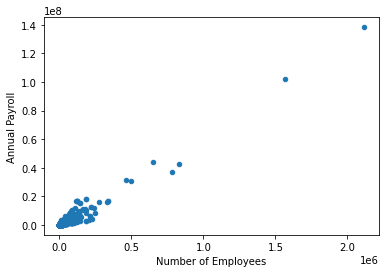

In [44]:
census_data.plot.scatter(
    x="Number of Employees",
    y="Annual Payroll"
)

I find that using the plotting tools in Pandas can sometimes be a bit more flexible--e.g., it can automatically generate subplots in very sensible ways--but you don't get quite as much control as you do using Matplotlib directly.  But for data that's already in a `DataFrame` that you just need a plot for, and you don't need a lot of fancy stuff, it' great!